In [1]:
import itertools
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
from math import *
import scipy
from tqdm import tqdm
from scipy.spatial import Delaunay

from utils import *


import matplotlib as mpl

# Set the default font and size
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 14

In [2]:
# add top-smart diauxer to the previous one. 
N_community = 20000
logD = log(100)

data = []
for R in range(2, 7):
    N = R
    communities = []
    stabilities = []
    for i in tqdm(range(N_community)):
        community = {}
        g = generate_g(N, R)
        permutations = list(itertools.permutations(list(range(1, R+1))))
        pref_list = np.array(random.choices(permutations, k=N))
        col = np.argmax(g, axis=1) # find column in g where it's the largest
        for row_i, row in enumerate(pref_list):
            index = np.where(row==col[row_i]+1)[0][0] # and switch this resource with the first-consumed one
            row[0], row[index] = row[index], row[0]

        dep_orders = allowed_orders(pref_list)
        N_dep_order = len(dep_orders)
        community["g"], community["pref_list"] = g, pref_list
        community["N_dep_orders"] = N_dep_order # allowed number of depletion orders, regardless of growth rates
        community["allowed_orders"] = dep_orders
        community["possible_dep_order"] = []
        for j in range(N_dep_order):
            dep_order = dep_orders[j]
            G = G_mat(g, pref_list, dep_order, N, R)
            if(np.linalg.matrix_rank(G)>=N):
                t = np.linalg.inv(G)@np.ones(R)*logD
                if(sum(t>0) >= len(t)):
                    community["possible_dep_order"].append(dep_order)
        communities.append(community)
    data.append({"R":R, "logD":logD, "communities":communities})
    
filename = "semismart_heatmap_diagonal.pkl"
pickle.dump(data, open(filename, "wb"))

  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [13:55<00:00, 23.93it/s]


In [4]:
# add smart diauxer to the previous one. 
N_community = 20000
logD = log(100)
data = []
for R in range(2, 7):
    N = R
    communities = []
    stabilities = []
    for i in tqdm(range(N_community)):
        community = {}
        g = generate_g(N, R)
        pref_list = smart_preference_list(g)
        dep_orders = allowed_orders(pref_list)
        N_dep_order = len(dep_orders)
        community["g"], community["pref_list"] = g, pref_list
        community["N_dep_orders"] = N_dep_order # allowed number of depletion orders, regardless of growth rates
        community["allowed_orders"] = dep_orders
        community["possible_dep_order"] = []
        for j in range(N_dep_order):
            dep_order = dep_orders[j]
            G = G_mat(g, pref_list, dep_order, N, R)
            if(np.linalg.matrix_rank(G)>=N):
                t = np.linalg.inv(G)@np.ones(R)*logD
                if(sum(t>0) >= len(t)):
                    community["possible_dep_order"].append(dep_order)
        communities.append(community)
    data.append({"R":R, "logD":logD, "communities":communities})
filename = "smart_heatmap_diagonal.pkl"
pickle.dump(data, open(filename, "wb"))

# add random diauxer to the previous one. 
N_community = 20000
logD = log(100)
data = []
for R in range(2, 7):
    N = R
    communities = []
    stabilities = []
    for i in tqdm(range(N_community)):
        community = {}
        g = generate_g(N, R)
        permutations = list(itertools.permutations(list(range(1, R+1))))
        pref_list = np.array(random.choices(permutations, k=N))
        dep_orders = allowed_orders(pref_list)
        N_dep_order = len(dep_orders)
        community["g"], community["pref_list"] = g, pref_list
        community["N_dep_orders"] = N_dep_order # allowed number of depletion orders, regardless of growth rates
        community["allowed_orders"] = dep_orders
        community["possible_dep_order"] = []
        for j in range(N_dep_order):
            dep_order = dep_orders[j]
            G = G_mat(g, pref_list, dep_order, N, R)
            if(np.linalg.matrix_rank(G)>=N):
                t = np.linalg.inv(G)@np.ones(R)*logD
                if(sum(t>0) >= len(t)):
                    community["possible_dep_order"].append(dep_order)
        communities.append(community)
    data.append({"R":R, "logD":logD, "communities":communities})
filename = "random_heatmap_diagonal.pkl"
pickle.dump(data, open(filename, "wb"))

# add coutilizers
N_community = 20000
logD = log(100)
data = []
for R in range(2, 7):
    N = R
    communities = []
    stabilities = []
    for i in tqdm(range(N_community)):
        community = {}
        g = generate_g(N, R)
        pref_list = smart_preference_list(g)
        x = np.tile(np.ones(R), (N, 1))
        dep_orders = np.array(list(itertools.permutations(list(range(1, R+1)))))
        N_dep_order = len(dep_orders)
        community["g"], community["x"] = g, x
        community["N_dep_orders"] = N_dep_order # allowed number of depletion orders, regardless of growth rates
        community["allowed_orders"] = dep_orders
        community["possible_orders"] = []
        for j in range(N_dep_order):
            dep_order = dep_orders[j]
            G = G_mat_co(g, x, dep_order, N, R)
            if(np.linalg.matrix_rank(G)>=N):
                t = np.linalg.inv(G)@np.ones(R)*logD
                if(sum(t>0) >= len(t)):
                    community["possible_orders"].append(dep_order)
        communities.append(community)
    data.append({"R":R, "logD":logD, "communities":communities})
filename = "uniformcoutilizer_heatmap_diagonal.pkl"
pickle.dump(data, open(filename, "wb"))

  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [2:04:05<00:00,  2.69it/s]  


In [2]:
# diversity versus stability
data = {"smart_diauxer":[[], []], "random_diauxer":[[], []], "coutilizer":[[], []]}

N_community = 10000
logD = log(100)

# smart diauxer
for R in range(2, 7):
    N = R
    filename = "smart_heatmap_diagonal.pkl"
    data_sub = pickle.load(open(filename, "rb"))
    communities = []
    stabilities = []
    stable = 0
    for item in data_sub:
        if(item["R"]==R):
            communities = item["communities"]
            break
    for item in communities[:N_community]:
        if(item["possible_dep_order"]!=[]):
            for dep_order in item["possible_dep_order"]:
                g, pref_list = item["g"], item["pref_list"]
                F = F_mat(g, pref_list, dep_order, logD, N, R)
                G = G_mat(g, pref_list, dep_order, N, R)
                t = np.linalg.inv(G)@np.ones(R)*logD
                env = {"N":N, "R":R, "logD":logD}
                if(np.abs(np.max(np.real(np.linalg.eigvals(Pert_mat(g, dep_order, G, t, F, env))))) < 1+1e-9):
                    stabilities.append( (log(np.abs(np.linalg.det(F))/(exp(logD)-1)**R)/log(10))/(R-1) )
                    stable += 1
                    break
    success_rate = stable/N_community
    stability = np.mean(stabilities)
    err = np.std(stabilities)/sqrt(len(stabilities))
    data["smart_diauxer"][0].append(success_rate)
    data["smart_diauxer"][1].append([stability, err])
    print(stability, success_rate)

# semismart diauxer
data["semismart_diauxer"] = [[], []]
for R in range(2, 7):
    N = R
    filename = "semismart_heatmap_diagonal.pkl"
    data_sub = pickle.load(open(filename, "rb"))
    communities = []
    stabilities = []
    stable = 0
    for item in data_sub:
        if(item["R"]==R):
            communities = item["communities"]
            break
    for item in communities[:N_community]:
        if(item["possible_dep_order"]!=[]):
            for dep_order in item["possible_dep_order"]:
                g, pref_list = item["g"], item["pref_list"]
                F = F_mat(g, pref_list, dep_order, logD, N, R)
                G = G_mat(g, pref_list, dep_order, N, R)
                t = np.linalg.inv(G)@np.ones(R)*logD
                env = {"N":N, "R":R, "logD":logD}
                if(np.abs(np.max(np.real(np.linalg.eigvals(Pert_mat(g, dep_order, G, t, F, env))))) < 1+1e-9):
                    stabilities.append( (log(np.abs(np.linalg.det(F))/(exp(logD)-1)**R)/log(10))/(R-1) )
                    stable += 1
                    break
    success_rate = stable/N_community
    stability = np.mean(stabilities)
    err = np.std(stabilities)/sqrt(len(stabilities))
    data["semismart_diauxer"][0].append(success_rate)
    data["semismart_diauxer"][1].append([stability, err])
    print(stability, success_rate)

# random diauxer
for R in range(2, 7):
    N = R
    filename = "random_heatmap_diagonal.pkl"
    data_sub = pickle.load(open(filename, "rb"))
    communities = []
    stabilities = []
    stable = 0
    for item in data_sub:
        if(item["R"]==R):
            communities = item["communities"]
            break
    for item in communities[:N_community]:
        if(item["possible_dep_order"]!=[]):
            for dep_order in item["possible_dep_order"]:
                g, pref_list = item["g"], item["pref_list"]
                F = F_mat(g, pref_list, dep_order, logD, N, R)
                G = G_mat(g, pref_list, dep_order, N, R)
                t = np.linalg.inv(G)@np.ones(R)*logD
                env = {"N":N, "R":R, "logD":logD}
                if(np.abs(np.max(np.real(np.linalg.eigvals(Pert_mat(g, dep_order, G, t, F, env))))) < 1+1e-9):
                    stabilities.append( (log(np.abs(np.linalg.det(F))/(exp(logD)-1)**R)/log(10))/(R-1) )
                    stable += 1
                    break
    success_rate = stable/N_community
    stability = np.mean(stabilities)
    err = np.std(stabilities)/sqrt(len(stabilities))
    data["random_diauxer"][0].append(success_rate)
    data["random_diauxer"][1].append([stability, err])
    print(stability, success_rate)

# uniform coutilizer
for R in range(2, 7):
    N = R
    filename = "uniformcoutilizer_heatmap_diagonal.pkl"
    data_sub = pickle.load(open(filename, "rb"))
    communities = []
    stabilities = []
    stable = 0
    for item in data_sub:
        if(item["R"]==R):
            communities = item["communities"]
            break
    for item in communities[:N_community]:
        if(item["possible_orders"]!=[]):
            for dep_order in  item["possible_orders"]:
                g, x = item["g"], item["x"]
                F = F_mat_co(g, x, dep_order, logD, N, R)
                G = G_mat_co(g, x, dep_order, N, R)
                t = np.linalg.inv(G)@np.ones(R)*logD
                env = {"N":N, "R":R, "logD":logD}
                if(np.abs(np.max(np.real(np.linalg.eigvals(Pert_mat_co(g, x, list(dep_order), G, t, F, env))))) < 1+1e-9):
                    stabilities.append( (log(np.abs(np.linalg.det(F))/(exp(logD)-1)**R)/log(10))/(R-1) )
                    stable += 1
                    break
    success_rate = stable/N_community
    stability = np.mean(stabilities)
    err = np.std(stabilities)/sqrt(len(stabilities))
    data["coutilizer"][0].append(success_rate)
    data["coutilizer"][1].append([stability, err])
    print(stability, success_rate)

-1.1156635452432992 0.4982
-1.1199446335007641 0.2414
-1.107476306266123 0.1179
-1.1169491365334832 0.0538
-1.1043009560713852 0.0248
-1.1323968350751912 0.5001
-1.0876551121109057 0.2765
-1.0863030931706352 0.1606
-1.0865414437172207 0.1014
-1.0765553716602307 0.067
-1.3201105077969262 0.4235
-1.3053413869481347 0.1478
-1.2301585543769136 0.0553
-1.3136579620382884 0.0171
-1.343190366508844 0.0061
-1.7320101410878939 0.4996
-1.8054003733362596 0.2525
-1.885494063377807 0.1265
-1.9385404375936874 0.0605
-1.9665066034174288 0.0299


[-0.0015662811355311203, -0.015202742910707194, -0.02539620791296726, -0.06509774167768603, -0.10039834085387778] [-1.1156635452432992, -1.1199446335007641, -1.107476306266123, -1.1169491365334832, -1.1043009560713852]
[-0.0721165896692931, -0.22826557461323072, -0.35418488170335816, -0.5628839069519214, -0.7095201866693269] [-1.3201105077969262, -1.3053413869481347, -1.2301585543769136, -1.3136579620382884, -1.343190366508844]
[-0.00034757463392091225, 0.004321373782642578, 0.005180512503780314, -0.014124642691606345, -0.019178833355664383] [-1.7320101410878939, -1.8054003733362596, -1.885494063377807, -1.9385404375936874, -1.9665066034174288]


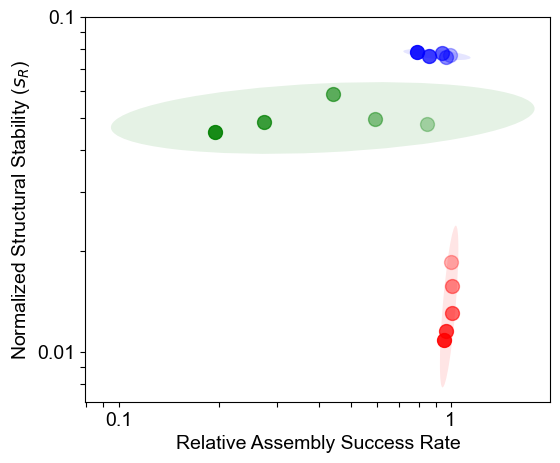

In [36]:
from matplotlib.patches import Ellipse
import matplotlib as mpl

alpha_list = np.arange(0.3, 1, 0.15)
color_list = ["b",  "g","r", "purple"]
keys_list = ["smart_diauxer", "random_diauxer", "coutilizer"]
legend_list = ["Sequential - Smart", "Sequential - Random", "Coutilization"]

plt.rcParams["figure.figsize"] = [6, 5]
fig, ax1 = plt.subplots()

for k_ind, k in enumerate(keys_list):
    for i in range(4):
        normalized_assembly = log10(data[k][0][i]*(2**(i+1)))
        stability = data[k][1][i][0]
        err = data[k][1][i][1]
        ax1.scatter(normalized_assembly, stability, marker='o', 
                     s = 100, alpha = alpha_list[i], color=color_list[k_ind])
    for i in range(4, 5):
        normalized_assembly = log10(data[k][0][i]*(2**(i+1)))
        stability = data[k][1][i][0]
        err = data[k][1][i][1]
        ax1.scatter(normalized_assembly, stability, marker='o', 
                     s = 100, alpha = alpha_list[i], color=color_list[k_ind], label=legend_list[k_ind])

for i, key in enumerate(keys_list):
    x_group, y_group = [log10(i*(2**(index+1))) for index, i in enumerate(data[key][0])], [i[0] for i in data[key][1]]
    print(x_group, y_group)
    center = np.mean([x_group, y_group], axis=1)
    cov_matrix = np.cov(x_group, y_group)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    width, height = 5*np.sqrt(eigenvalues)
    ellipse = Ellipse(center, width, height, angle=angle, facecolor=color_list[i], alpha=0.1)
    ax1.add_patch(ellipse)

xlo, xhi, ylo, yhi = -1.1, 0.3, -2.15, -1
ax1.set_xlim(xlo, xhi)
ax1.set_ylim(ylo, yhi)
a, b = ticking(xlo, xhi)
ax1.set_xticks(a, b)
a, b = ticking(ylo, yhi)
ax1.set_yticks(a, b)
# ax1.set_xticks([-1, -0.5, 0], ["$10^{-1}$", "$10^{-0.5}$", "$10^0$"])
# ax1.set_yticks([-1, -1.5, -2], ["$10^{-1}$", "$10^{-1.5}$", "$10^{-2}$"])
ax1.set_xlabel("Relative Assembly Success Rate")
ax1.set_ylabel("Normalized Structural Stability ($s_R$)")
plt.savefig("figures/met_strat_clouds.pdf", bbox_inches="tight")

In [13]:
list(np.arange(-1, 0, 0.1))

[-1.0,
 -0.9,
 -0.8,
 -0.7000000000000001,
 -0.6000000000000001,
 -0.5000000000000001,
 -0.40000000000000013,
 -0.30000000000000016,
 -0.20000000000000018,
 -0.1000000000000002]

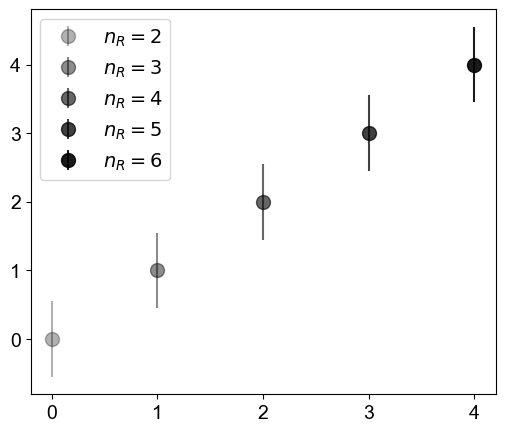

In [20]:
# another legend
label_list = ["$n_R=2$", "$n_R=3$", "$n_R=4$", "$n_R=5$", "$n_R=6$"]

for i in range(5):
    plt.errorbar([i], [i], yerr=0.55, marker='o', markersize=10, color='k', alpha=alpha_list[i], label = label_list[i])

# gratias magnas chatGPT
handles, labels = plt.gca().get_legend_handles_labels()
# Modify the legend handles to remove the horizontal line
for handle in handles:
    handle[0].set_linestyle('none')
plt.legend(handles, labels)

plt.savefig("figures/shades_legend.pdf")